Demonstration of using Spiral from `spiral.py` to estimate multiple variables (though one works too) in a PTV framework.  This simulation uses a Poisson noise model, but others can be employed in this optimizer.  Some are already defined in `loss.py` and users can create their own using the framework defined in that file.

Processing with 

In [1]:
import sys,os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import importlib

In [2]:
# load file path information from the home directory
file_path_yml = os.path.join(os.environ["HOME"], ".ncar_config_derecho.yaml")
path_data = {}
with open(file_path_yml, "r") as r:
    path_data = yaml.safe_load(r)

In [3]:
dirP_str = os.path.join(
    path_data["ptv_collection_path"], "SpiralTorch", "python"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [4]:
from SpiralTorch import spiral
from SpiralTorch import loss

In [5]:
# use this block to autodetect if a GPU is available
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
# device = torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

dtype = torch.float64

Preparing to use device cuda:0


# Simulate Poisson Observations
Generate a scene of data similar to depolarization where one channel observes a parallel and perpendicular polarization term such that the mean photon flux in each channel is

$\alpha_1 = \beta(1-d/2)$

$\alpha_2 = \frac{1}{2}\beta d$

and the observations are 

$y_1 \sim Poisson(\alpha_1)$

$y_2 \sim Poisson(\alpha_2)$

In [6]:
x_axis = np.linspace(-10,10,64)
y_axis = np.linspace(-10,10,128)
x_ax_mesh,y_ax_mesh = np.meshgrid(x_axis,y_axis)

rec_count = 80
ch_count = 2

# uniform distribution
# rec_x_position_arr = 20*(np.random.rand(rec_count)-0.5)
# rec_y_position_arr = 20*(np.random.rand(rec_count)-0.5)
# normal distribution
rec_x_position_arr = 5*(np.random.randn(rec_count))
rec_y_position_arr = 5*(np.random.randn(rec_count))
rec_x_arr = np.random.randn(rec_count)*5
rec_y_arr = np.random.randn(rec_count)*5
beta_rec_arr = 20*np.random.rand(rec_count)
d_rec_arr = np.random.rand(rec_count)

beta_bg = 4
d_bg = 0.1

alpha_arr_lst = []
for idx in range(ch_count):
    if idx == 0:
        alpha_arr_lst.append(np.zeros((y_axis.size,x_axis.size))+0.5*beta_bg*(1-d_bg))
    elif idx == 1:
        alpha_arr_lst.append(np.zeros((y_axis.size,x_axis.size))+0.5*beta_bg*d_bg)

for idx in range(rec_count):
    rec_idx = np.where((y_ax_mesh >= rec_y_position_arr[idx]-rec_y_arr[idx]/2) & (y_ax_mesh <= rec_y_position_arr[idx]+rec_y_arr[idx]/2) & \
             (x_ax_mesh >= rec_x_position_arr[idx]-rec_x_arr[idx]/2) & (x_ax_mesh <= rec_x_position_arr[idx]+rec_x_arr[idx]/2))
    
    alpha_arr_lst[0][rec_idx]+=beta_rec_arr[idx]*(1-0.5*d_rec_arr[idx])
    alpha_arr_lst[1][rec_idx]+=0.5*beta_rec_arr[idx]*d_rec_arr[idx]

In [7]:
x_act = {
    'beta':alpha_arr_lst[0]+alpha_arr_lst[1],
    'd':2*alpha_arr_lst[1]/(alpha_arr_lst[1]+alpha_arr_lst[0])
}

In [8]:
y_obs_fit_lst = []
y_obs_val_lst = []
# create fit and validation data for the scene
for ch_idx, alpha_arr in enumerate(alpha_arr_lst):
    y_obs_fit_lst.append(np.random.poisson(alpha_arr))
    y_obs_val_lst.append(np.random.poisson(alpha_arr))

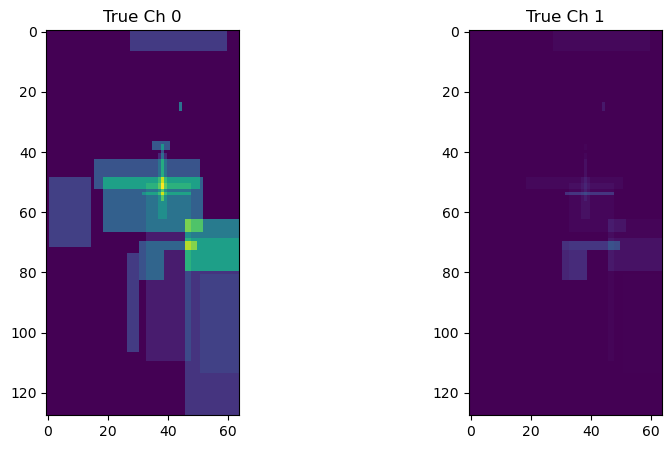

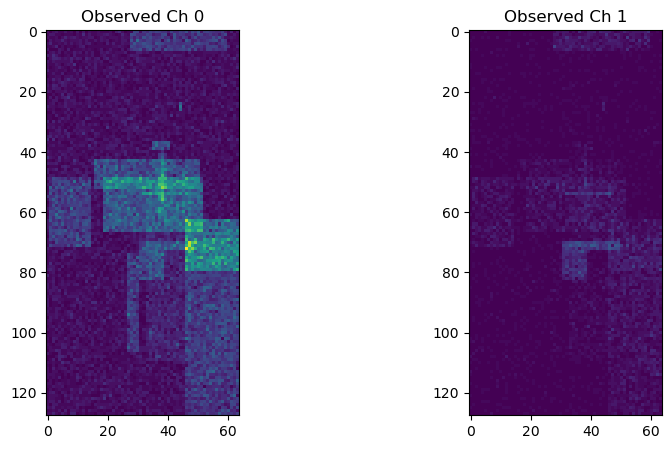

In [9]:
fig,ax = plt.subplots(1,len(alpha_arr_lst),figsize=(10,5))
for ch_idx, alpha_arr in enumerate(alpha_arr_lst):
    im = ax[ch_idx].imshow(alpha_arr)
    ax[ch_idx].set_title(f"True Ch {ch_idx}")
    if ch_idx == 0:
        clim = im.get_clim()
    else:
        im.set_clim(clim)

fig,ax = plt.subplots(1,len(alpha_arr_lst),figsize=(10,5))
for ch_idx, y_arr in enumerate(y_obs_fit_lst):
    im = ax[ch_idx].imshow(y_arr)
    ax[ch_idx].set_title(f"Observed Ch {ch_idx}")
    if ch_idx == 0:
        clim = im.get_clim()
    else:
        im.set_clim(clim)

# Process Scene using Spiral TV with regularizer optimization

In [10]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'

Set up a grid search to locate the optimal regularization for each estimated variable

In [11]:
tv_reg_dct = {
    'd':np.logspace(0.8,1.5,5),
    'beta':np.logspace(0,0.7,5),
}

In [12]:
# create regularizer grid
tv_lst = []
for var in tv_reg_dct:
    tv_lst.append(tv_reg_dct[var])

tv_mesh_tup = np.meshgrid(*tv_lst)

grid_count = tv_mesh_tup[0].size

Define forward models for each observation channel

In [13]:
def parallel_pois_fwd_model(**x):
    """
    forward model for parallel polarization channel
    
    expects x['beta'] - backscatter
            x['d'] - depolarization
    returns 
            fwd_mod['y_mean_est']
    """
    fwd_mod = {
        'y_mean_est':torch.exp(x['beta'])*(1-x['d']*0.5)
    }
    return fwd_mod

def perp_pois_fwd_model(**x):
    """
    forward model for perpendicular polarization channel
    
    expects x['beta'] - backscatter
            x['d'] - depolarization
    returns 
            fwd_mod['y_mean_est']
    """
    fwd_mod = {
        'y_mean_est':0.5*torch.exp(x['beta'])*x['d']
    }
    return fwd_mod

Set the foward model list and load the observations to correspond with the forward models.  Observations should consist of statistically independent `fit` (for optimization) and `validation` (for optimizing the TV regularization) data.

In [14]:
fwd_model_lst = [
    parallel_pois_fwd_model,
    perp_pois_fwd_model,
]

y_fit_dct_lst = []
y_val_dct_lst = []

for idx, y_fit in enumerate(y_obs_fit_lst):
    y_fit_dct_lst.append({'counts':y_fit})
    y_val_dct_lst.append({'counts':y_obs_val_lst[idx]})



In [15]:
# create spiral optimization object
spiral_opt = spiral.multiSpiral_autograd(device,dtype)  # these terms were set in the cell used to autodetect a GPU
spiral_opt.set_fista_version(fista_ver_str)  # set the FISTA version ('jit-fista' by default)
spiral_opt.set_fwd_model_lst(fwd_model_lst)  # load the forward models into the optimizer
spiral_opt.set_y_fit_lst(y_fit_dct_lst)   # load the fit data into the optimizer
spiral_opt.set_y_val_lst(y_val_dct_lst)   # load the validation data into the optimizer
spiral_opt.set_noise_model(['poisson','poisson'])  # set the noise model to be used for each channel (they don't have to be the same)

In [16]:
# check for alignment between observations and the noise model inputs
pass_test_bool, out_text, = spiral_opt.check_noise_model_inputs()
print(f"check passed: {pass_test_bool}")
print(out_text)

check passed: True
fit data is does not have a dictionary entry for optional input channel_mask in channel 0
validation data is does not have a dictionary entry for optional input channel_mask in channel 0
fit data is does not have a dictionary entry for optional input channel_weight in channel 0
validation data is does not have a dictionary entry for optional input channel_weight in channel 0
fit data is does not have a dictionary entry for optional input channel_mask in channel 1
validation data is does not have a dictionary entry for optional input channel_mask in channel 1
fit data is does not have a dictionary entry for optional input channel_weight in channel 1
validation data is does not have a dictionary entry for optional input channel_weight in channel 1



In [17]:
sparsa_subprob_config_dct = {
    'beta':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    'd':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    }
    }

In [18]:
# set the initial conditions
x0 = {
    'beta':np.zeros(y_obs_fit_lst[0].shape)+np.log(10),
    'd':np.zeros(y_obs_fit_lst[0].shape)+0.1,
}

In [19]:
# set the variables to be estimated (and order in which they are optimizers)
spiral_opt.set_estimate_lst(['beta','d'])

# this is where the subproblems for each variable get created, so there needs to be an entry for each
spiral_opt.add_sparsa_config(sparsa_subprob_config_dct)
spiral_opt.set_initial_conditions(x0)
# spiral_opt.set_tv_penalties({'beta':1e0,'d':1e1})  # this must happen after the subproblem is defined
spiral_opt.verbose = False

Run the spiral optimizer over the regularizer search space.  Store the Validation NLL for each outcome

In [ ]:
x_sol_lst = []
vld_loss_lst = []
opt_time_lst = []
for idx in range(grid_count):
    tv_dct = {}
    for var_idx, var in enumerate(tv_reg_dct):
        tv_dct[var] = tv_mesh_tup[var_idx].flatten()[idx]
        print(var+f": {tv_mesh_tup[var_idx].flatten()[idx]}")
    spiral_opt.set_tv_penalties(tv_dct)  # this must happen after the subproblem is defined
    
    # reinitialize
    # spiral_opt.set_alpha(1.0)
    spiral_opt.set_initial_conditions(x0)
    
    # optimize
    spiral_opt.solve()

    # store result
    x_sol = spiral_opt.get_x()
    x_sol_lst.append(x_sol)
    vld_loss = spiral_opt.valid_loss()  # this is used for TV regularization optimization
    vld_loss_lst.append(vld_loss)
    opt_time_lst.append(spiral_opt.stop_time - spiral_opt.start_time)
    print(f"validation loss: {vld_loss}")
    print(f"optimization time: {opt_time_lst[-1]} seconds")
    print()

d: 6.3095734448019325
beta: 1.0
validation loss: -44881.95485835686
optimization time: 130.00664496421814 seconds

d: 9.440608762859235
beta: 1.0
validation loss: -44821.5871988062
optimization time: 138.39858675003052 seconds

d: 14.12537544622754
beta: 1.0
validation loss: -44721.699728114334
optimization time: 133.12793970108032 seconds

d: 21.134890398366466
beta: 1.0
validation loss: -44570.66377738132
optimization time: 128.06916975975037 seconds

d: 31.622776601683796
beta: 1.0
validation loss: -44402.08301245804
optimization time: 122.65776562690735 seconds

d: 6.3095734448019325
beta: 1.4962356560944334
validation loss: -45062.7619328399
optimization time: 119.26991844177246 seconds

d: 9.440608762859235
beta: 1.4962356560944334
validation loss: -45002.39427328927
optimization time: 133.7377574443817 seconds

d: 14.12537544622754
beta: 1.4962356560944334
validation loss: -44902.506802597374
optimization time: 129.30815386772156 seconds

d: 21.134890398366466
beta: 1.4962356560

Locate the best solution then display the results

In [ ]:
sol_idx = np.argmin(vld_loss_lst)
x_sol = x_sol_lst[sol_idx]

In [ ]:
# plot the regularizer search space
# the lowest validation NLL is the best TV regularization
var_idx_x = 0
var_idx_y = 1

fig,ax = plt.subplots(1,1,figsize=(5,5))
tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
tv_var_y = list(tv_reg_dct.keys())[var_idx_y]

im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),tv_mesh_tup[var_idx_y].flatten(),c=vld_loss_lst)
ax.plot(tv_mesh_tup[var_idx_x].flatten()[sol_idx],tv_mesh_tup[var_idx_y].flatten()[sol_idx],'wx')
ax.set_xlabel(tv_var_x + " Regularizer")
ax.set_ylabel(tv_var_y + " Regularizer")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(visible=True)
plt.colorbar(im,ax=ax,label="validation NLL")

In [ ]:
# plot the optimal solution and actual data (from the simulation) for comparison
plt_x_dct = {
    'beta':{'function':np.exp,'label':r'$\beta$'},
    'd':{'label':r'$d$'}
}
clim_dct = {}

fig,ax = plt.subplots(1,len(x_act.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_act_test):
    im = ax[var_idx].imshow(x_act_test[var])
    ax[var_idx].set_title(f"Actual "+plt_x_dct[var]['label'])
    clim_dct[var] = im.get_clim()
    plt.colorbar(im,ax=ax[var_idx])
    

fig,ax = plt.subplots(1,len(x_sol.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_sol):
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    im = ax[var_idx].imshow(plot_arr)
    ax[var_idx].set_title(f"Estimated "+plt_x_dct[var]['label'])
    im.set_clim(clim_dct[var])
    plt.colorbar(im,ax=ax[var_idx])

In [ ]:
# calculate the forward model of the solution for each observation channel
fwd_model_dct_lst = []

x_sol_tnsr = {}

for var in x_sol:
    x_sol_tnsr[var] = spiral_opt.to_tensor(x_sol[var])

for idx, model in enumerate(spiral_opt.fwd_model_lst):
    y_est = model(**x_sol_tnsr)
    fwd_dct = {}
    for var in y_est:
        fwd_dct[var] = y_est[var].detach().cpu()
    fwd_model_dct_lst.append(fwd_dct)

In [ ]:
# plot a cross section of the forward model
obs_var = 'counts'
fwd_mod_var = 'y_mean_est'
time_idx = 20

for idx, fwd_mod in enumerate(fwd_model_dct_lst):
    plt.figure()
    plt.plot(y_fit_dct_lst[idx][obs_var][time_idx,:],label='observation')
    plt.plot(alpha_arr_lst[idx][time_idx,:],label='actual')
    plt.plot(fwd_mod[fwd_mod_var][time_idx,:],label='estimate')
    plt.legend()
    plt.title(f"Channel {idx}")